In [1]:
import sys
dir_repo = '../'
sys.path.append(dir_repo)

from galaxy_generator.utils import get_config_from_yaml
from galaxy_generator.vae_generator import VAE_Generator

In [2]:
config = get_config_from_yaml(dir_repo+'configs/vae_run0.yaml')
generator = VAE_Generator(config=config)


------ Parameters ------

exp_name : vae_run0
cuda : True
gpu_device : 0
workers : 2
dir_image : /home/hhg/Research/galaxyClassify/catalog/galaxyZoo_kaggle/gz2_images/images
file_csv : /home/hhg/Research/galaxyClassify/catalog/galaxyZoo/zoo2/gz2_all_v2.csv
label_tag : label_8
num_classes : 8
class_weights : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
f_train : 0.85
f_valid : 0.15
seed : 3
crop_size : 224
input_size : 64
n_channel : 3
n_zlatent : 50
n_filter_E : 64
n_filter_D : 64
num_epochs : 50
batch_size : 64
lr : 0.001
beta1 : 0.5
beta2 : 0.999
step_size : 5
gamma : 0.1
early_stop_threshold : 10
dir_output : /home/hhg/Research/galaxyClassify/repo/GalaxyZooGenerator/experiments
freq_img : 2
Ngals : 9
dpi : 100

------ Prepare Data ------

Number of train galaxies: 132558 (2072 batches)
Number of valid galaxies: 23393 (366 batches)

------ Build Model ------

Number of trainable parameters
Encoder  : 4415876
Decoder  : 3285056

------ Encoder Output Layer Dimensions ------

Input shape:

## Load the `trainInfo` file

- ``trainInfo`` stores the resulting generator and discrimintor losses at each iteration (`train_loss`, `valid_loss`), the averaged losses at each epoch (`epoch_train_loss`, `epoch_valid_loss`), as well ad the learning rate used (`lr`). 

In [3]:
import pickle

print(f'open file : {generator.file_trainInfo}')
trainInfo = pickle.load(file = open(generator.file_trainInfo, 'rb'))

open file : /home/hhg/Research/galaxyClassify/repo/GalaxyZooGenerator/experiments/vae_run0/trainInfo.pkl


In [4]:
trainInfo.keys()

dict_keys(['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr', 'valid_means', 'valid_logvars', 'valid_labels', 'best_epochID', 'best_model_state_dict'])

## Display Training Losses and Learning Rate

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

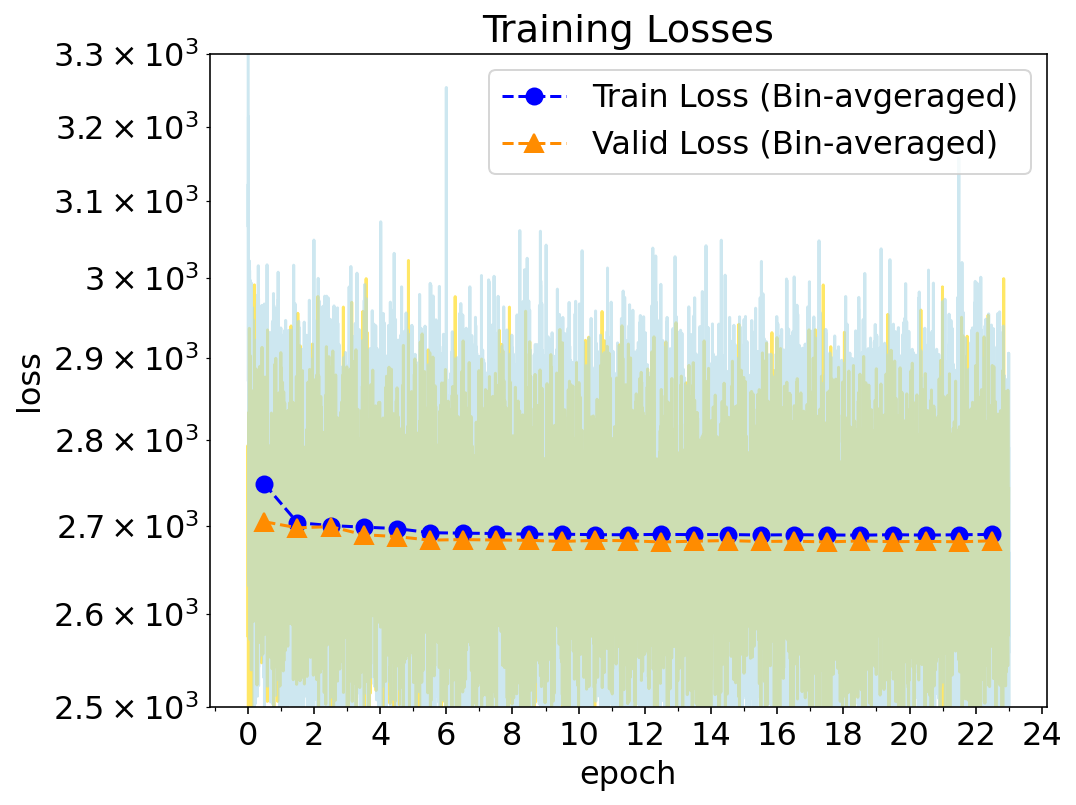

In [6]:
###### Parameters ######
#end = 30
########################

plt.rc('font', size=16)
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))

iter_tick = np.array(range(len(trainInfo['train_loss'])))/len(generator.dataloader['train'])
epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5
ax.plot(iter_tick , trainInfo['train_loss'], color='lightblue', alpha=0.6, zorder=-1)
ax.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='Train Loss (Bin-avgeraged)', color='b', markersize=8)


iter_tick = np.array(range(len(trainInfo['valid_loss'])))/len(generator.dataloader['valid'])
epoch_tick = np.array(range(len(trainInfo['epoch_valid_loss'])))+0.5
ax.plot(iter_tick, trainInfo['valid_loss'], color='gold', alpha=0.6, zorder=-2)
ax.plot(epoch_tick, trainInfo['epoch_valid_loss'], '^--', label='Valid Loss (Bin-averaged)', color='darkorange', markersize=9)

ax.set_title(f'Training Losses')

ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
#ax.set_xlim([0, end])
ax.set_ylim([2.5e3, 3.3e3])
ax.xaxis.set_major_locator(MultipleLocator(2))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

#file_fig = '/home/hhg/Research/galaxyClassify/repo/GalaxyZooGenerator/out_loss.png'
#fig.savefig(file_fig, dpi=300, transparent=False, facecolor='white')

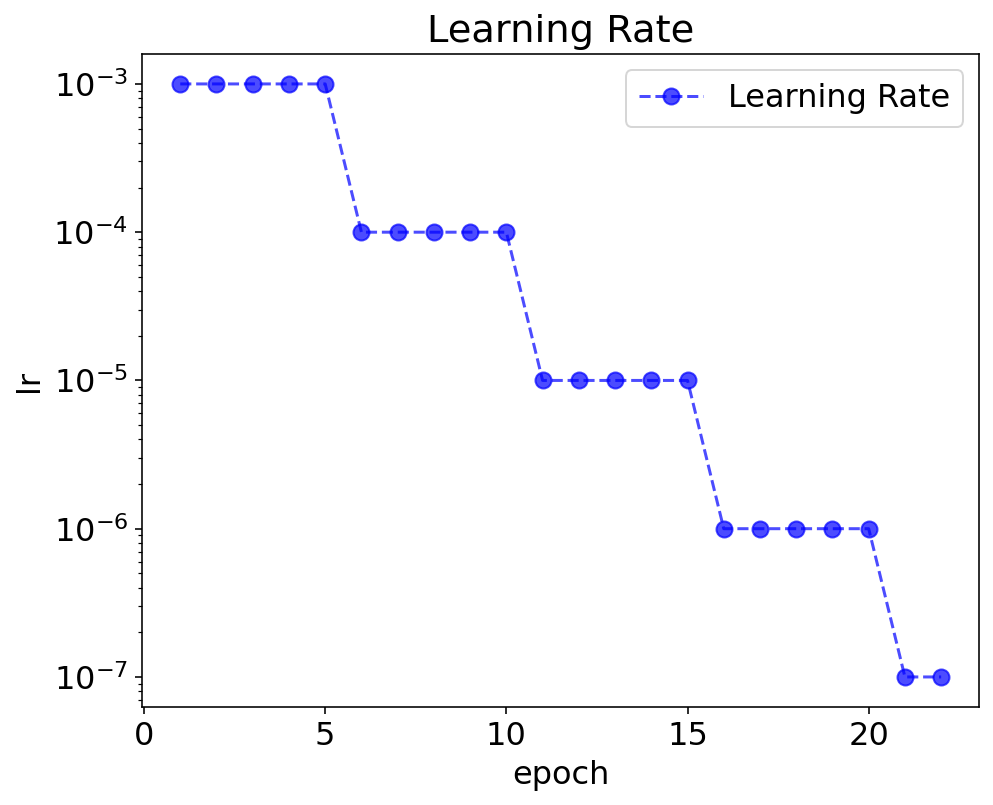

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
plt.rc('font', size=16)

epoch_tick = np.array(range(len(trainInfo['lr']))) + 1

ax.plot(epoch_tick[:], trainInfo['lr'][:], 'o--', label='Learning Rate', color='b', markersize=8, alpha=0.7)

ax.set_title(f'Learning Rate')


ax.set_yscale('log')
ax.set_ylabel('lr')
ax.set_xlabel('epoch')
ax.legend()

#file_fig = '/home/hhg/Research/galaxyClassify/repo/GalaxyZooGenerator/out_lr.png'
#fig.savefig(file_fig, dpi=300, transparent=False, facecolor='white')
#plt.close(fig)

## Draw Galaxy Images

- Use the class method `generator.gen_galaxy` to display generator images at each `epochID`.

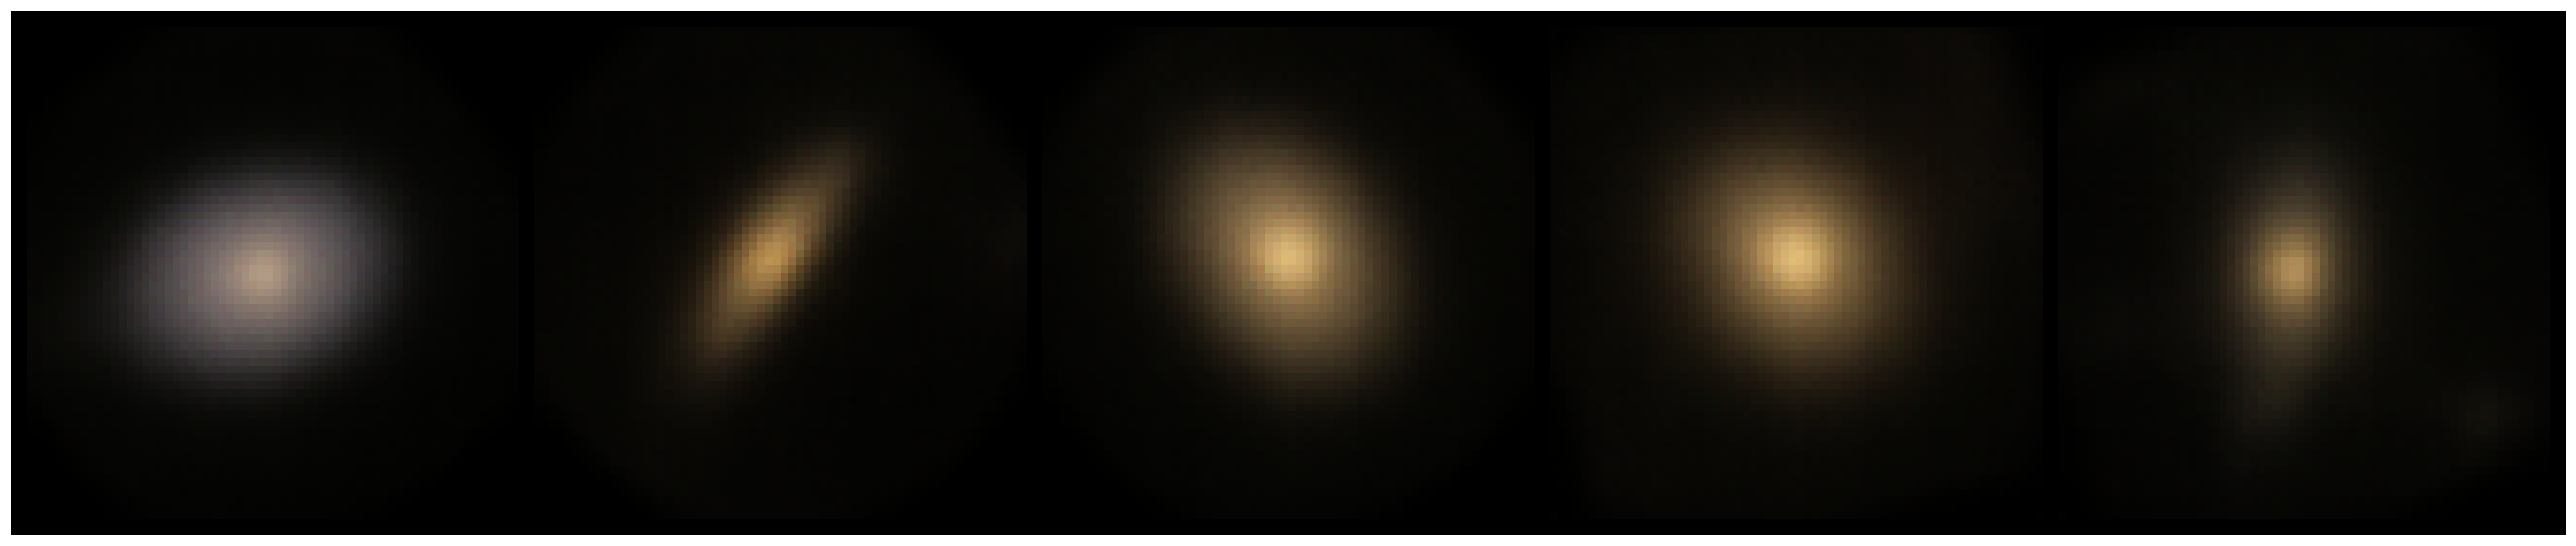

In [8]:
Ngals = 5
epochID = 0
nrow = 1
img_grid = generator.gen_galaxy(Ngals, epochID, nrow=nrow)

# ------ plots ------
fig = plt.figure( figsize=(5*(Ngals//nrow), 5.1*nrow) )
plt.axis("off")
plt.imshow(img_grid)
plt.tight_layout()

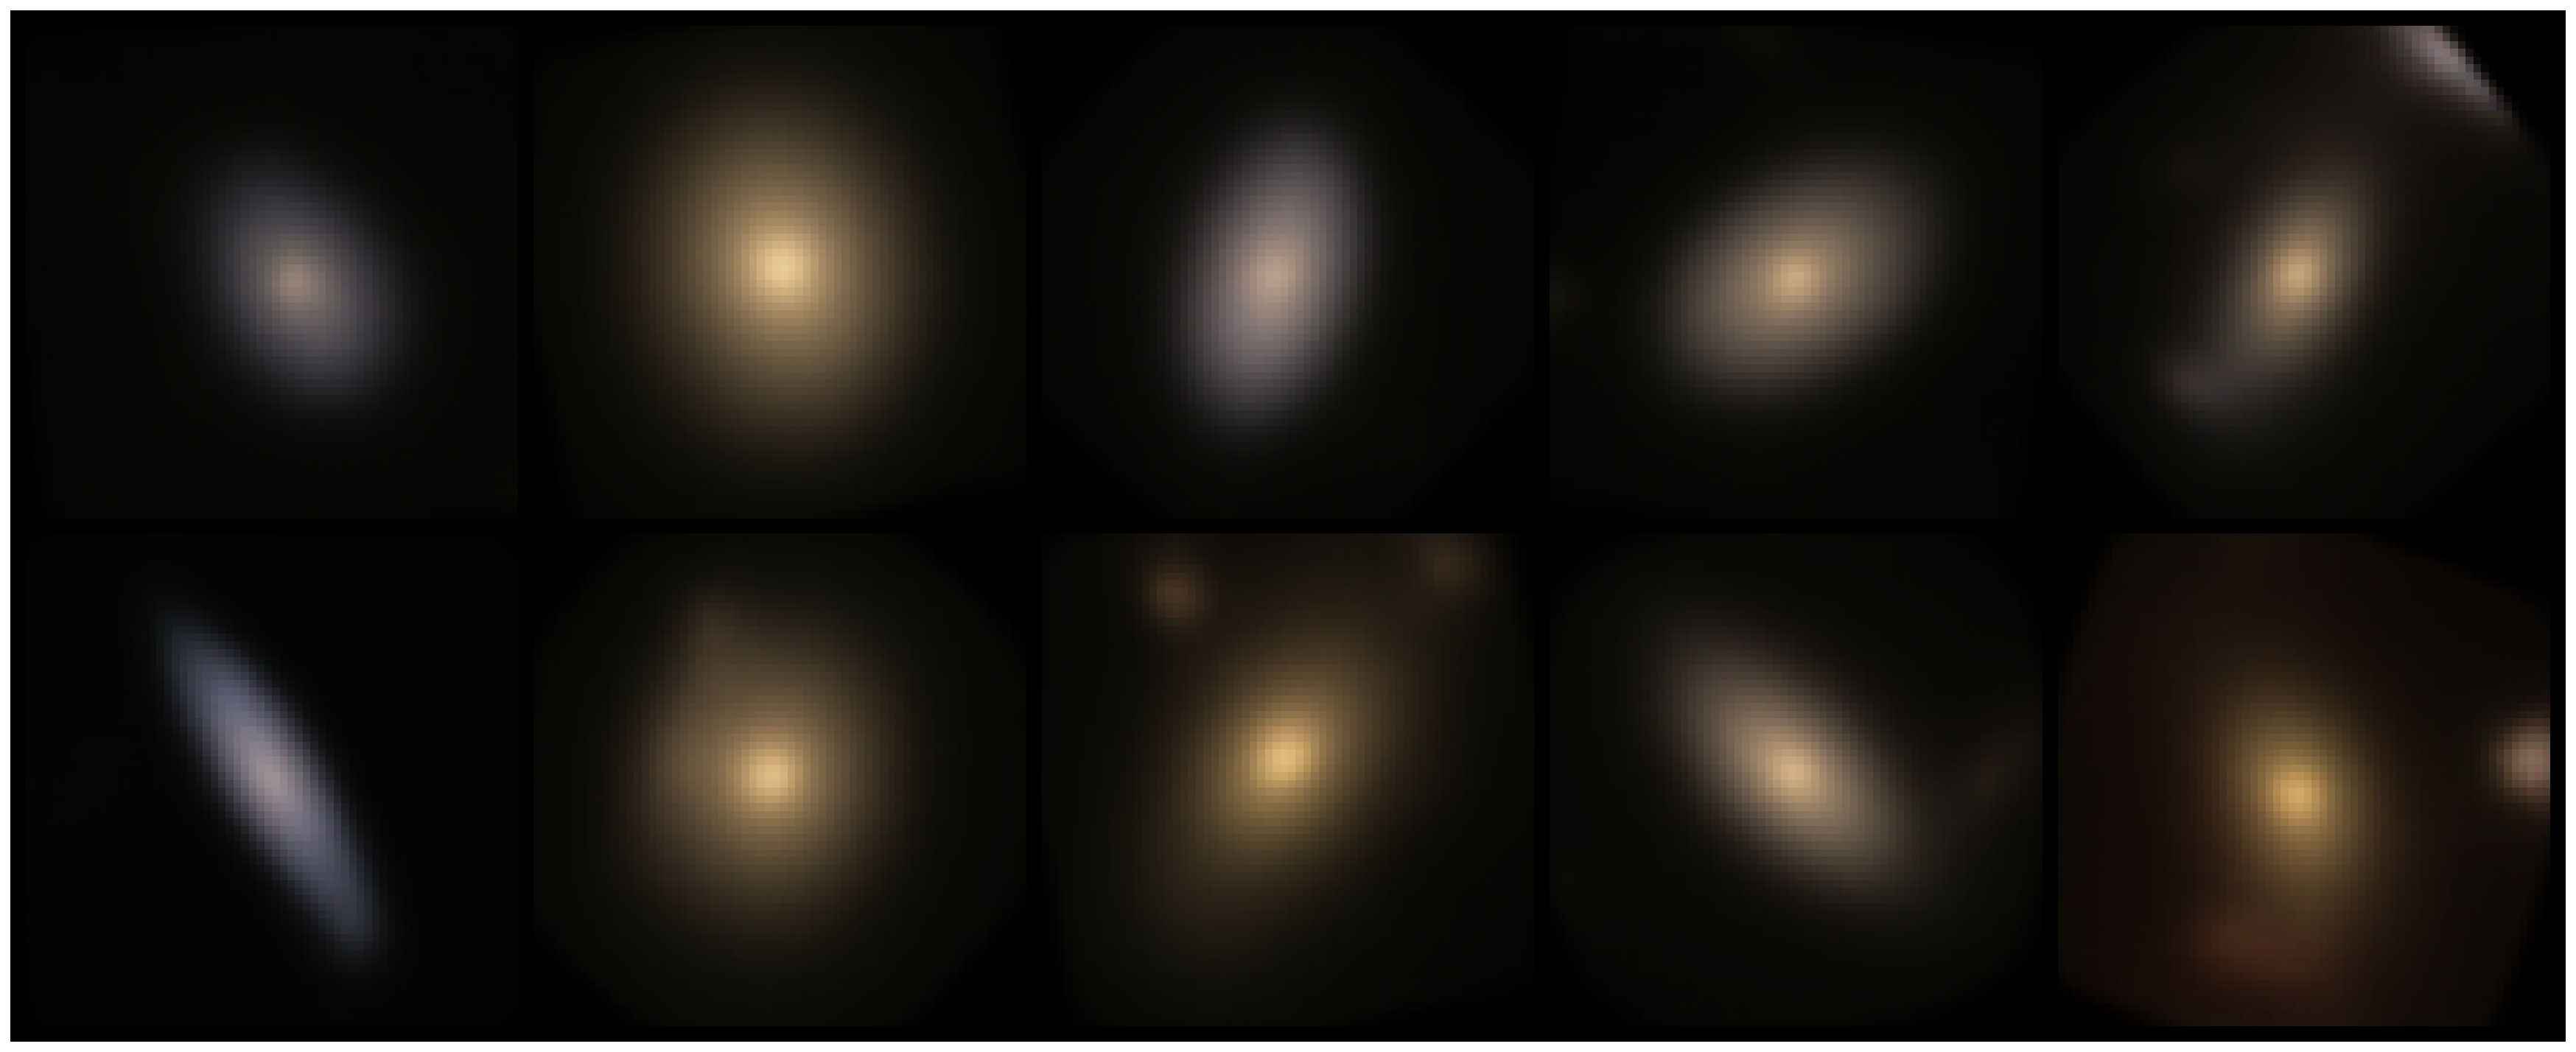

In [9]:
Ngals = 10
epochID = 22
nrow = 2
img_grid = generator.gen_galaxy(Ngals, epochID, nrow=nrow)

# ------ plots ------
fig = plt.figure( figsize=(5*(Ngals//nrow), 5.1*nrow) )
plt.axis("off")
plt.imshow(img_grid)
plt.tight_layout()

# file_fig = f'/home/hhg/Research/galaxyClassify/repo/GalaxyZooGenerator/out_{epochID}.png'
# fig.savefig(file_fig, dpi=300, transparent=False, facecolor='white')
# plt.close(fig)

## Explore the Latent Space

In [10]:
labels_dict = {0:'Round Elliptical', 1:'In-between Elliptical', 2:'Cigar-shaped Elliptical', 3:'Edge-on Spiral',
               4:'Barred Spiral', 5: 'Unbarred Spiral', 6:'Irregular', 7:'Merger'}

### t-SNE

In [11]:
from sklearn.manifold import TSNE

In [12]:
trainInfo['valid_means'][0].shape

torch.Size([23393, 50])

In [13]:
N = 1000  # samples per epoch
epochs = (0, 4, 14)

X, Y, E = [], [], []  # input, classes, embeddings
for epoch in epochs:
    X.append(trainInfo['valid_means'][epoch][:N].cpu())
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(trainInfo['valid_labels'][epoch][:N])

[Text(1, 0.0, 'Round Elliptical'),
 Text(1, 1.0, 'In-between Elliptical'),
 Text(1, 2.0, 'Cigar-shaped Elliptical'),
 Text(1, 3.0, 'Edge-on Spiral'),
 Text(1, 3.9999999999999996, 'Barred Spiral'),
 Text(1, 5.0, 'Unbarred Spiral'),
 Text(1, 6.0, 'Irregular'),
 Text(1, 7.0, 'Merger')]

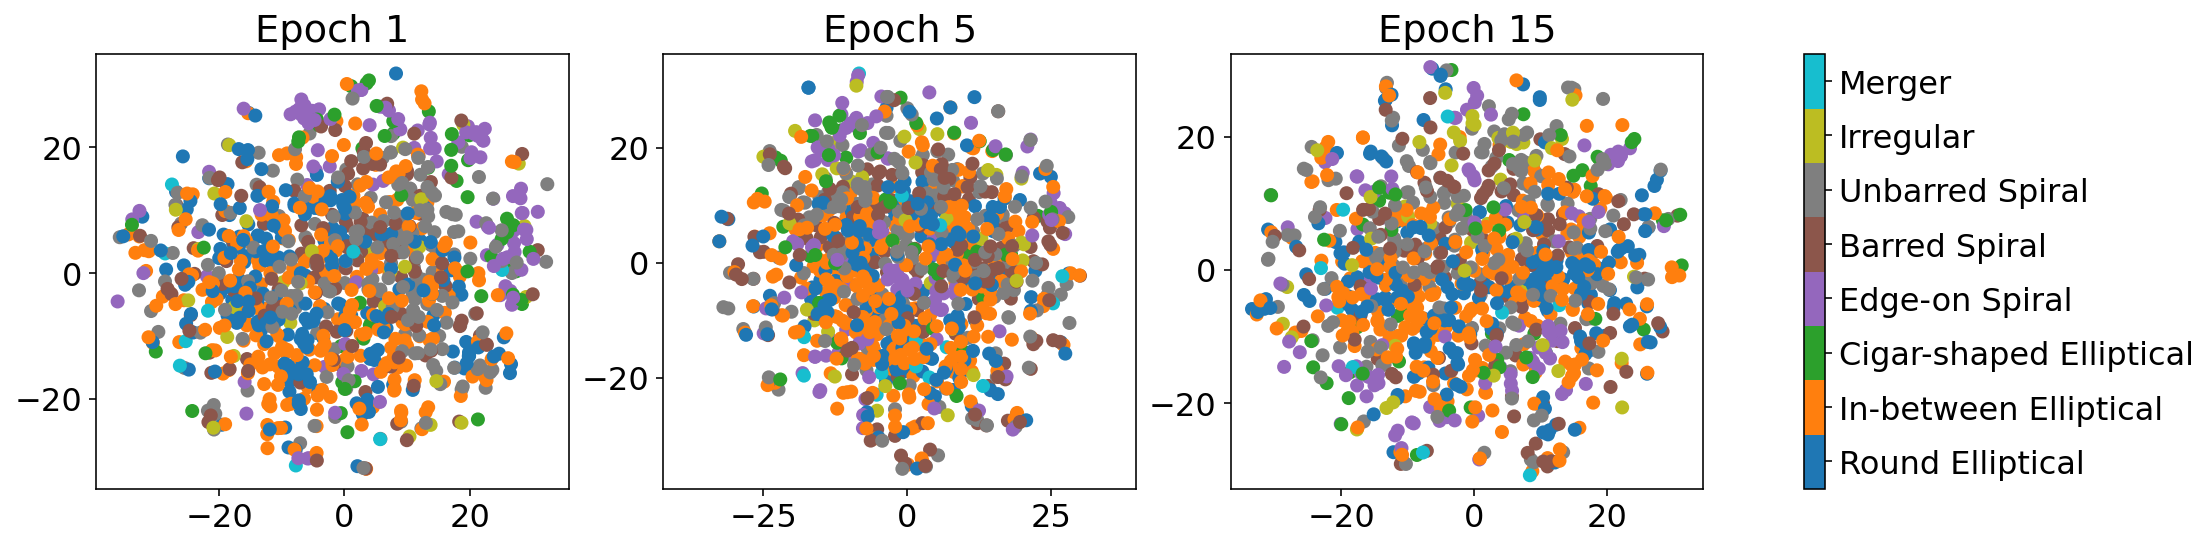

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))

for i, e in enumerate(epochs):
    s = ax[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    ax[i].grid(False)
    ax[i].set_title(f'Epoch {e+1}')
    ax[i].axis('equal')

cbar = fig.colorbar(s, ax=ax[:], ticks=np.arange(8), boundaries=np.arange(9) - 0.5)

cbar.ax.set_yticklabels([labels_dict[i] for i in range(8)])


### U-Map

In [15]:
import umap

In [16]:
N = 1000  # samples per epoch
epochs = (0, 4, 14)

X, Y, E = [], [], []  # input, classes, embeddings
for epoch in epochs:
    X.append(trainInfo['valid_means'][epoch][:N].cpu())
    E.append(umap.UMAP(n_neighbors=5).fit_transform(X[-1]))
    Y.append(trainInfo['valid_labels'][epoch][:N])

[Text(1, 0.0, 'Round Elliptical'),
 Text(1, 1.0, 'In-between Elliptical'),
 Text(1, 2.0, 'Cigar-shaped Elliptical'),
 Text(1, 3.0, 'Edge-on Spiral'),
 Text(1, 3.9999999999999996, 'Barred Spiral'),
 Text(1, 5.0, 'Unbarred Spiral'),
 Text(1, 6.0, 'Irregular'),
 Text(1, 7.0, 'Merger')]

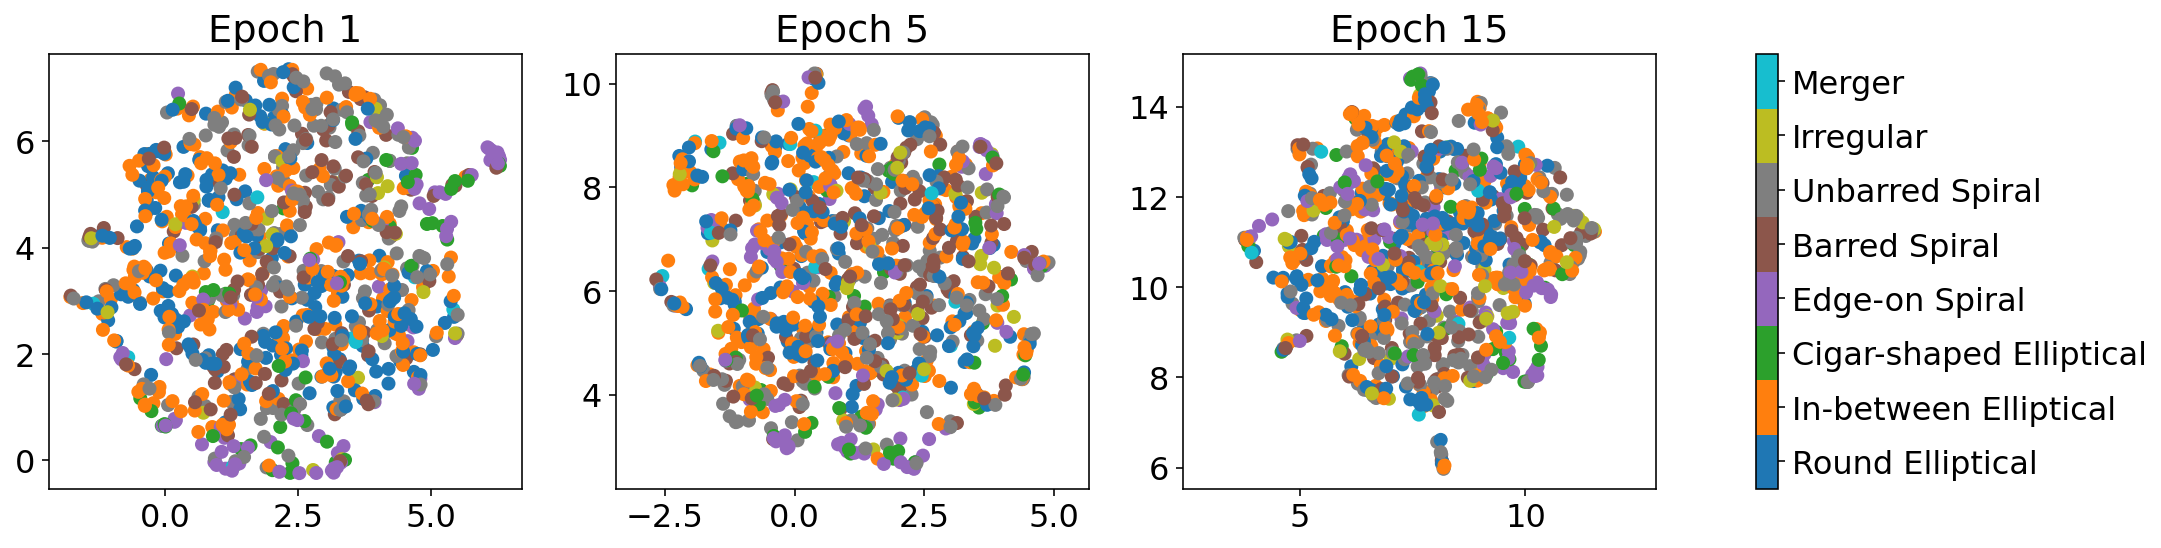

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))

for i, e in enumerate(epochs):
    s = ax[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    ax[i].grid(False)
    ax[i].set_title(f'Epoch {e+1}')
    ax[i].axis('equal')

cbar = fig.colorbar(s, ax=ax[:], ticks=np.arange(8), boundaries=np.arange(9) - 0.5)
cbar.ax.set_yticklabels([labels_dict[i] for i in range(8)])
